In [5]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
from monai.metrics import DiceMetric, MeanIoU, SurfaceDiceMetric, SSIMMetric, GeneralizedDiceScore
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset
import torch.distributed as dist
from torchvision import transforms
from transformers.models.maskformer.modeling_maskformer import dice_loss, sigmoid_focal_loss
from sahi.utils.coco import Coco
from sahi.utils.cv import get_bool_mask_from_coco_segmentation

PyTorch version: 1.13.1
Torchvision version: 0.14.1
CUDA is available: True


In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

In [3]:
image_folder = 'C:\Study\Segment Anything\kvasir-seg\images'
mask_folder = 'C:\Study\Segment Anything\kvasir-seg\masks'
save_folder = 'C:\Study\Segment Anything\kvasir-seg\predict'
os.makedirs(save_folder, exist_ok = True)

image_path = []
mask_path = []

for root, dirs, files in os.walk(image_folder, topdown=False): #finds MRI files
    for name in files:
        if name.endswith(".jpg"):
            apath=os.path.join(root, name)
            image_path.append(apath)
            
for root, dirs, files in os.walk(mask_folder, topdown=False): #finds MRI files
    for name in files:
        if name.endswith(".jpg"):
            apath=os.path.join(root, name)
            mask_path.append(apath)
            
print(image_path[-1], mask_path[-1])

with open('C:\Study\Segment Anything\kvasir-seg\\kavsir_bboxes.json') as f:
    labels = json.load(f)

  

C:\Study\Segment Anything\kvasir-seg\images\ck2da7fwcjfis07218r1rvm95.jpg C:\Study\Segment Anything\kvasir-seg\masks\ck2da7fwcjfis07218r1rvm95.jpg


In [105]:

from collections import defaultdict, deque
import pickle

import numpy as np
from PIL import Image

import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.distributed as dist
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

import segmentation_models_pytorch as smp

from transformers.models.maskformer.modeling_maskformer import dice_loss, sigmoid_focal_loss


# coco mask style dataloader
class ColonDataset(Dataset):
    def __init__(self, data_root, image_size):
        self.data_root = data_root
        self.image_size = image_size
        annotation = os.path.join(data_root, "_annotations.coco.json")
        self.coco = Coco.from_coco_dict_or_path(annotation)

        # TODO: use ResizeLongestSide and pad to square
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.image_resize = transforms.Resize((image_size, image_size), interpolation=Image.BILINEAR)

    def __len__(self):
        return len(self.coco.images)

    def __getitem__(self, index):
        coco_image = self.coco.images[index]
        image = Image.open(os.path.join(self.data_root, self.split, coco_image.file_name)).convert("RGB")
        original_width, original_height = image.width, image.height
        ratio_h = self.image_size / image.height
        ratio_w = self.image_size / image.width
        image = self.image_resize(image)
        image = self.to_tensor(image)
        image = self.normalize(image)

        bboxes = []
        masks = []
        labels = []
        for annotation in coco_image.annotations:
            x, y, w, h = annotation.bbox
            # get scaled bbox in xyxy format
            bbox = [x * ratio_w, y * ratio_h, (x + w) * ratio_w, (y + h) * ratio_h]
            mask = get_bool_mask_from_coco_segmentation(annotation.segmentation, original_width, original_height)
            mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_LINEAR)
            mask = (mask > 0.5).astype(np.uint8)
            label = annotation.category_id
            bboxes.append(bbox)
            masks.append(mask)
            labels.append(label)
        bboxes = np.stack(bboxes, axis=0)
        masks = np.stack(masks, axis=0)
        labels = np.stack(labels, axis=0)
        return image, torch.tensor(bboxes), torch.tensor(masks).long()
    
    @classmethod
    def collate_fn(cls, batch):
        images, bboxes, masks = zip(*batch)
        images = torch.stack(images, dim=0)
        return images, bboxes, masks


class SAMFinetuner(pl.LightningModule):

    def __init__(
            self,
            model_type,
            checkpoint_path,
            freeze_image_encoder=False,
            freeze_prompt_encoder=False,
            freeze_mask_decoder=False,
            batch_size=1,
            learning_rate=1e-4,
            weight_decay=1e-4,
            train_dataset=None,
            val_dataset=None,
            metrics_interval=10,
        ):
        super(SAMFinetuner, self).__init__()

        self.model_type = model_type
        self.model = sam_model_registry[self.model_type](checkpoint=checkpoint_path)
        self.model.to(device=self.device)
        self.freeze_image_encoder = freeze_image_encoder
        if freeze_image_encoder:
            for param in self.model.image_encoder.parameters():
                param.requires_grad = False
        if freeze_prompt_encoder:
            for param in self.model.prompt_encoder.parameters():
                param.requires_grad = False
        if freeze_mask_decoder:
            for param in self.model.mask_decoder.parameters():
                param.requires_grad = False
        
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

        self.train_metric = defaultdict(lambda: deque(maxlen=metrics_interval))

        self.metrics_interval = metrics_interval

    def forward(self, imgs, bboxes, labels):
        _, _, H, W = imgs.shape
        features = self.model.image_encoder(imgs)
        num_masks = sum([len(b) for b in bboxes])

        loss_focal = loss_dice = loss_iou = 0.
        predictions = []
        tp, fp, fn, tn = [], [], [], []
        for feature, bbox, label in zip(features, bboxes, labels):
            # Embed prompts
            sparse_embeddings, dense_embeddings = self.model.prompt_encoder(
                points=None,
                boxes=bbox,
                masks=None,
            )
            # Predict masks
            low_res_masks, iou_predictions = self.model.mask_decoder(
                image_embeddings=feature.unsqueeze(0),
                image_pe=self.model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False,
            )
            # Upscale the masks to the original image resolution
            masks = F.interpolate(
                low_res_masks,
                (H, W),
                mode="bilinear",
                align_corners=False,
            )
            predictions.append(masks)
            # Compute the iou between the predicted masks and the ground truth masks
            batch_tp, batch_fp, batch_fn, batch_tn = smp.metrics.get_stats(
                masks,
                label.unsqueeze(1),
                mode='binary',
                threshold=0.5,
            )
            batch_iou = smp.metrics.iou_score(batch_tp, batch_fp, batch_fn, batch_tn)
            # Compute the loss
            masks = masks.squeeze(1).flatten(1)
            label = label.flatten(1)
            loss_focal += sigmoid_focal_loss(masks, label.float(), num_masks)
            loss_dice += dice_loss(masks, label.float(), num_masks)
            loss_iou += F.mse_loss(iou_predictions, batch_iou, reduction='sum') / num_masks
            tp.append(batch_tp)
            fp.append(batch_fp)
            fn.append(batch_fn)
            tn.append(batch_tn)
        return {
            'loss': 20. * loss_focal + loss_dice + loss_iou,  # SAM default loss
            'loss_focal': loss_focal,
            'loss_dice': loss_dice,
            'loss_iou': loss_iou,
            'predictions': predictions,
            'tp': torch.cat(tp),
            'fp': torch.cat(fp),
            'fn': torch.cat(fn),
            'tn': torch.cat(tn),
        }
    
    def training_step(self, batch, batch_nb):
        imgs, bboxes, labels = batch
        outputs = self(imgs, bboxes, labels)

        for metric in ['tp', 'fp', 'fn', 'tn']:
            self.train_metric[metric].append(outputs[metric])

        # aggregate step metics
        step_metrics = [torch.cat(list(self.train_metric[metric])) for metric in ['tp', 'fp', 'fn', 'tn']]
        per_mask_iou = smp.metrics.iou_score(*step_metrics, reduction="micro-imagewise")
        metrics = {
            "loss": outputs["loss"],
            "loss_focal": outputs["loss_focal"],
            "loss_dice": outputs["loss_dice"],
            "loss_iou": outputs["loss_iou"],
            "train_per_mask_iou": per_mask_iou,
        }
        self.log_dict(metrics, prog_bar=True, rank_zero_only=True)
        return metrics
    
    def validation_step(self, batch, batch_nb):
        imgs, bboxes, labels = batch
        outputs = self(imgs, bboxes, labels)
        outputs.pop("predictions")
        return outputs
    
    def validation_epoch_end(self, outputs):
        if NUM_GPUS > 1:
            outputs = all_gather(outputs)
            # the outputs are a list of lists, so flatten it
            outputs = [item for sublist in outputs for item in sublist]
        # aggregate step metics
        step_metrics = [
            torch.cat(list([x[metric].to(self.device) for x in outputs]))
            for metric in ['tp', 'fp', 'fn', 'tn']]
        # per mask IoU means that we first calculate IoU score for each mask
        # and then compute mean over these scores
        per_mask_iou = smp.metrics.iou_score(*step_metrics, reduction="micro-imagewise")

        metrics = {"val_per_mask_iou": per_mask_iou}
        self.log_dict(metrics)
        return metrics
    
    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        def warmup_step_lr_builder(warmup_steps, milestones, gamma):
            def warmup_step_lr(steps):
                if steps < warmup_steps:
                    lr_scale = (steps + 1.) / float(warmup_steps)
                else:
                    lr_scale = 1.
                    for milestone in sorted(milestones):
                        if steps >= milestone * self.trainer.estimated_stepping_batches:
                            lr_scale *= gamma
                return lr_scale
            return warmup_step_lr
        scheduler = torch.optim.lr_scheduler.LambdaLR(
            opt,
            warmup_step_lr_builder(250, [0.66667, 0.86666], 0.1)
        )
        return {
            'optimizer': opt,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': "step",
                'frequency': 1,
            }
        }
    
    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(
            self.train_dataset,
            collate_fn=self.train_dataset.collate_fn,
            batch_size=self.batch_size,
            num_workers=NUM_WORKERS,
            shuffle=True)
        return train_loader
    
    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(
            self.val_dataset,
            collate_fn=self.val_dataset.collate_fn,
            batch_size=self.batch_size,
            num_workers=NUM_WORKERS,
            shuffle=False)
        return val_loader



In [118]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# sam_checkpoint = "sam_vit_h_4b8939.pth"
# model_type = "vit_h"

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"


device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
sam.train();


In [ ]:

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--data_root", type=str, required=True, help="path to the data root")
    parser.add_argument("--model_type", type=str, required=True, help="model type", choices=['vit_h', 'vit_l', 'vit_b'])
    parser.add_argument("--checkpoint_path", type=str, required=True, help="path to the checkpoint")
    parser.add_argument("--freeze_image_encoder", action="store_true", help="freeze image encoder")
    parser.add_argument("--freeze_prompt_encoder", action="store_true", help="freeze prompt encoder")
    parser.add_argument("--freeze_mask_decoder", action="store_true", help="freeze mask decoder")
    parser.add_argument("--batch_size", type=int, default=1, help="batch size")
    parser.add_argument("--image_size", type=int, default=1024, help="image size")
    parser.add_argument("--steps", type=int, default=1500, help="number of steps")
    parser.add_argument("--learning_rate", type=float, default=1e-4, help="learning rate")
    parser.add_argument("--weight_decay", type=float, default=1e-2, help="weight decay")
    parser.add_argument("--metrics_interval", type=int, default=50, help="interval for logging metrics")
    parser.add_argument("--output_dir", type=str, default=".", help="path to save the model")

    args = parser.parse_args()

    # load the dataset
    train_dataset = Coco2MaskDataset(data_root=args.data_root, split="train", image_size=args.image_size)
    val_dataset = Coco2MaskDataset(data_root=args.data_root, split="val", image_size=args.image_size)

    # create the model
    model = SAMFinetuner(
        args.model_type,
        args.checkpoint_path,
        freeze_image_encoder=args.freeze_image_encoder,
        freeze_prompt_encoder=args.freeze_prompt_encoder,
        freeze_mask_decoder=args.freeze_mask_decoder,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        batch_size=args.batch_size,
        learning_rate=args.learning_rate,
        weight_decay=args.weight_decay,
        metrics_interval=args.metrics_interval,
    )

    callbacks = [
        LearningRateMonitor(logging_interval='step'),
        ModelCheckpoint(
            dirpath=args.output_dir,
            filename='{step}-{val_per_mask_iou:.2f}',
            save_last=True,
            save_top_k=1,
            monitor="val_per_mask_iou",
            mode="max",
            save_weights_only=True,
            every_n_train_steps=args.metrics_interval,
        ),
    ]
    trainer = pl.Trainer(
        strategy='ddp' if NUM_GPUS > 1 else None,
        accelerator=DEVICE,
        devices=NUM_GPUS,
        precision=32,
        callbacks=callbacks,
        max_epochs=-1,
        max_steps=args.steps,
        val_check_interval=args.metrics_interval,
        check_val_every_n_epoch=None,
        num_sanity_val_steps=0,
    )

    trainer.fit(model)


if __name__ == "__main__":
    main()


In [119]:
from segment_anything.utils.transforms import ResizeLongestSide
transformed_data = defaultdict(dict)

i = 0

idx = image_path[i].split('images\\')[1].split('.jpg')[0]


# bbox = labels[idx]['bbox']
# print(bbox)
# print(bbox[0]['xmin'], bbox[1]['xmin'], bbox[2]['xmin'])
# print([i['xmin'] for i in labels[idx]['bbox']])

# bbox_coords = {}

# for i in range(len(bbox)):

#     x_coord = [i['xmin'] for i in labels[idx]['bbox']]
#     y_coord = [i['ymin'] for i in labels[idx]['bbox']]
#     xx_coord = [i['xmax'] for i in labels[idx]['bbox']]
#     yy_coord = [i['ymax'] for i in labels[idx]['bbox']]

#     bbox = np.array([x, y, x + w, y + h])


image = cv2.imread(image_path[i])
gt = cv2.imread(mask_path[i])
gt = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY) / 255
gt = gt.astype('float32')

transform = ResizeLongestSide(sam.image_encoder.img_size)
input_image = transform.apply_image(image)

input_image_torch = torch.as_tensor(input_image, device=device)
transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

input_image = sam.preprocess(transformed_image)
original_image_size = image.shape[:2]
input_size = tuple(transformed_image.shape[-2:])
# gt_resized = transform.apply_image(gt)


transformed_data[0]['image'] = input_image
transformed_data[0]['input_size'] = input_size
transformed_data[0]['original_image_size'] = original_image_size

print(original_image_size)

(529, 622)


In [120]:
from monai.losses import GeneralizedDiceLoss, DiceLoss, GeneralizedDiceFocalLoss

# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-6
wd = 1e-4
optimizer = torch.optim.AdamW(sam.mask_decoder.parameters(), lr=lr, weight_decay=wd)

# loss_fn = GeneralizedDiceLoss(include_background=False, to_onehot_y=False, sigmoid=True, softmax=False)
loss_fn = DiceLoss(include_background=False, to_onehot_y=False, sigmoid=True, softmax=False)


from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize


num_epochs = 80
losses = []
batch = 1
for epoch in range(num_epochs):
    epoch_losses = []
  # Just train on the first 20 examples
    for k in range(0, batch):
        input_image = transformed_data[k]['image'].to(device)
        input_size = transformed_data[k]['input_size']
        original_image_size = transformed_data[k]['original_image_size']

    # No grad here as we don't want to optimise the encoders
        with torch.no_grad():
            image_embedding = sam.image_encoder(input_image)

            prompt_box = np.array([38,5,430,338])

            box = transform.apply_boxes(prompt_box, original_image_size)
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            box_torch = box_torch[None, :]

#             prompt_box = np.array([619, 151, 622, 285])
        
#             box = transform.apply_boxes(prompt_box, original_image_size)
#             box_torch2 = torch.as_tensor(box, dtype=torch.float, device=device)
#             box_torch2 = box_torch2[None, :]

            sparse_embeddings, dense_embeddings = sam.prompt_encoder(
              points=None,
              boxes=box_torch,
              masks=None,
            )
        
        low_res_masks, iou_predictions = sam.mask_decoder(
          image_embeddings=image_embedding,
          image_pe=sam.prompt_encoder.get_dense_pe(),
          sparse_prompt_embeddings=sparse_embeddings,
          dense_prompt_embeddings=dense_embeddings,
          multimask_output=False,
        )

        upscaled_masks = sam.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)

        binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

        gt_mask_resized = torch.from_numpy(gt).to(device)
        
        gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)
        
        # gt_binary_mask = gt_mask_resized
        
        print(binary_mask.size(), gt_binary_mask.size())

        loss = loss_fn(binary_mask, gt_binary_mask.unsqueeze(0).unsqueeze(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        
    losses.append(epoch_losses)
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')


torch.Size([1, 1, 529, 622]) torch.Size([529, 622])
EPOCH: 0
Mean loss: 0.5209853649139404
torch.Size([1, 1, 529, 622]) torch.Size([529, 622])
EPOCH: 1
Mean loss: 0.5209715366363525
torch.Size([1, 1, 529, 622]) torch.Size([529, 622])
EPOCH: 2
Mean loss: 0.5209630727767944
torch.Size([1, 1, 529, 622]) torch.Size([529, 622])
EPOCH: 3
Mean loss: 0.5209530591964722
torch.Size([1, 1, 529, 622]) torch.Size([529, 622])
EPOCH: 4
Mean loss: 0.5209521055221558
torch.Size([1, 1, 529, 622]) torch.Size([529, 622])
EPOCH: 5
Mean loss: 0.5209445357322693
torch.Size([1, 1, 529, 622]) torch.Size([529, 622])
EPOCH: 6
Mean loss: 0.5209410190582275
torch.Size([1, 1, 529, 622]) torch.Size([529, 622])
EPOCH: 7
Mean loss: 0.5209383368492126
torch.Size([1, 1, 529, 622]) torch.Size([529, 622])
EPOCH: 8
Mean loss: 0.520931601524353
torch.Size([1, 1, 529, 622]) torch.Size([529, 622])
EPOCH: 9
Mean loss: 0.520916759967804
torch.Size([1, 1, 529, 622]) torch.Size([529, 622])
EPOCH: 10
Mean loss: 0.5209169387817383


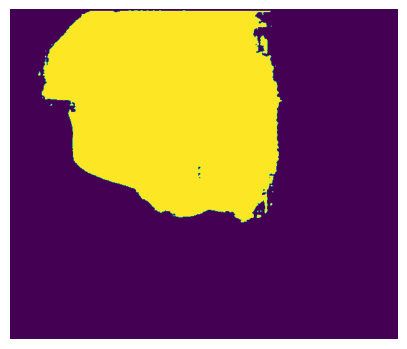

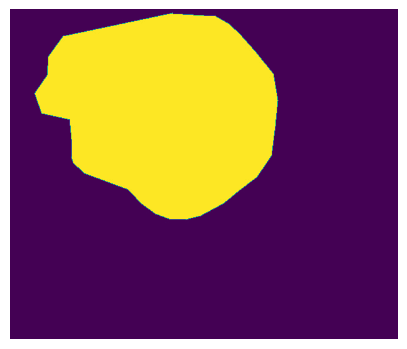

In [121]:
plt.figure(figsize=(5,5))
plt.imshow(binary_mask.detach().cpu().numpy()[0, 0])
plt.axis('off')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(gt_binary_mask.detach().cpu().numpy())
plt.axis('off')
plt.show()




In [57]:
from monai.losses import GeneralizedDiceLoss

# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-4
wd = 1e-4

parameters = list(sam.mask_decoder.parameters()) + list(sam.image_encoder.parameters())

optimizer = torch.optim.AdamW(parameters, lr=lr, weight_decay=wd)

loss_fn = GeneralizedDiceLoss(include_background=False, to_onehot_y=False, sigmoid=True, softmax=False)

from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize


num_epochs = 100
losses = []
batch = 1
for epoch in range(num_epochs):
    epoch_losses = []
  # Just train on the first 20 examples
    for k in range(0, batch):
        input_image = transformed_data[k]['image'].to(device)
        input_size = transformed_data[k]['input_size']
        original_image_size = transformed_data[k]['original_image_size']
        
        image_embedding = sam.image_encoder(input_image)
        
        prompt_box = np.array([486, 42, 622, 339])
            
#              "bbox": [{"label": "polyp", "xmin": 486, "ymin": 42, "xmax": 622, "ymax": 339}, 
                      
#                       {"label": "polyp", "xmin": 329, "ymin": 71, "xmax": 437, "ymax": 150}, 
                      
#                       {"label": "polyp", "xmin": 619, "ymin": 151, "xmax": 622, "ymax": 285}]}, 

        box = transform.apply_boxes(prompt_box, original_image_size)
        box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
        box_torch = box_torch[None, :]

        sparse_embeddings, dense_embeddings = sam.prompt_encoder(
          points=None,
          boxes=None,
          masks=None,
        )
        
        low_res_masks, iou_predictions = sam.mask_decoder(
          image_embeddings=image_embedding,
          image_pe=sam.prompt_encoder.get_dense_pe(),
          sparse_prompt_embeddings=sparse_embeddings,
          dense_prompt_embeddings=dense_embeddings,
          multimask_output=False,
        )

        upscaled_masks = sam.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)

        binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

        gt_mask_resized = torch.from_numpy(gt).to(device)
        
        gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)
        
        print(binary_mask.size(), gt_binary_mask.size())

        loss = loss_fn(binary_mask, gt_binary_mask.unsqueeze(0).unsqueeze(0))
        
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        optimizer.zero_grad()
        
    losses.append(epoch_losses)
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')


torch.Size([1, 1, 528, 622]) torch.Size([528, 622])
EPOCH: 0
Mean loss: 0.7664244771003723
torch.Size([1, 1, 528, 622]) torch.Size([528, 622])
EPOCH: 1
Mean loss: 0.7640216946601868
torch.Size([1, 1, 528, 622]) torch.Size([528, 622])
EPOCH: 2
Mean loss: 0.7640216946601868
torch.Size([1, 1, 528, 622]) torch.Size([528, 622])
EPOCH: 3
Mean loss: 0.7640216946601868
torch.Size([1, 1, 528, 622]) torch.Size([528, 622])
EPOCH: 4
Mean loss: 0.7640216946601868
torch.Size([1, 1, 528, 622]) torch.Size([528, 622])
EPOCH: 5
Mean loss: 0.7640216946601868
torch.Size([1, 1, 528, 622]) torch.Size([528, 622])
EPOCH: 6
Mean loss: 0.7640216946601868
torch.Size([1, 1, 528, 622]) torch.Size([528, 622])
EPOCH: 7
Mean loss: 0.7640216946601868
torch.Size([1, 1, 528, 622]) torch.Size([528, 622])
EPOCH: 8
Mean loss: 0.7640216946601868
torch.Size([1, 1, 528, 622]) torch.Size([528, 622])
EPOCH: 9
Mean loss: 0.7640216946601868
torch.Size([1, 1, 528, 622]) torch.Size([528, 622])
EPOCH: 10
Mean loss: 0.764021694660186

EPOCH: 89
Mean loss: 0.7640216946601868
torch.Size([1, 1, 528, 622]) torch.Size([528, 622])
EPOCH: 90
Mean loss: 0.7640216946601868
torch.Size([1, 1, 528, 622]) torch.Size([528, 622])
EPOCH: 91
Mean loss: 0.7640216946601868
torch.Size([1, 1, 528, 622]) torch.Size([528, 622])
EPOCH: 92
Mean loss: 0.7640216946601868
torch.Size([1, 1, 528, 622]) torch.Size([528, 622])
EPOCH: 93
Mean loss: 0.7640216946601868
torch.Size([1, 1, 528, 622]) torch.Size([528, 622])
EPOCH: 94
Mean loss: 0.7640216946601868
torch.Size([1, 1, 528, 622]) torch.Size([528, 622])
EPOCH: 95
Mean loss: 0.7640216946601868
torch.Size([1, 1, 528, 622]) torch.Size([528, 622])
EPOCH: 96
Mean loss: 0.7640216946601868
torch.Size([1, 1, 528, 622]) torch.Size([528, 622])
EPOCH: 97
Mean loss: 0.7640216946601868
torch.Size([1, 1, 528, 622]) torch.Size([528, 622])
EPOCH: 98
Mean loss: 0.7640216946601868
torch.Size([1, 1, 528, 622]) torch.Size([528, 622])
EPOCH: 99
Mean loss: 0.7640216946601868


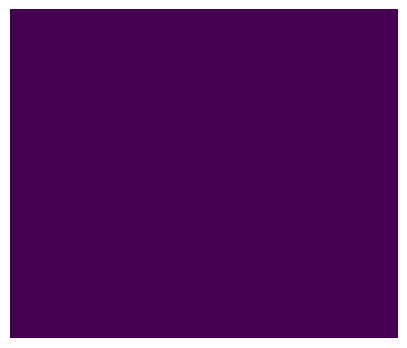

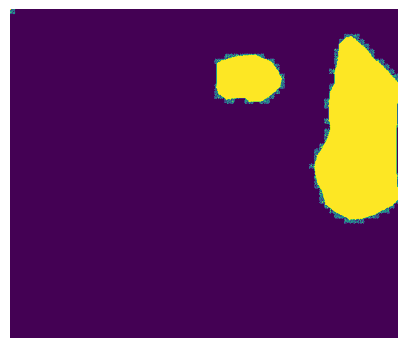

In [58]:
plt.figure(figsize=(5,5))
plt.imshow(binary_mask.detach().cpu().numpy()[0, 0])
plt.axis('off')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(gt_binary_mask.detach().cpu().numpy())
plt.axis('off')
plt.show()


